# New Algorithms for Simulating Dynamical Friction

## Dan T. Abell, David L. Bruhwiler, Stephen D. Webb — *RadiaSoft, LLC*

This notebook describes—and documents in code—algorithms for simulating  
the dynamical friction experienced by ions in the presence of magnetized electrons.

The $\LaTeX$ preamble is *here*.
$$
%% math text
\newcommand{\hmhsp}{\mspace{1mu}}% math hair space
\newcommand{\mhsp}{\mspace{2mu}}% math hair space
\newcommand{\ud}{\mathop{}\!\mathrm{d}}% upright d for differential
\newcommand{\ui}{\mathrm{i}}% upright i for imaginary unit
\newcommand{\ue}{\mathrm{e}}% upright e for Euler number
%%
\newcommand{\Mion}{m_\text{ion}}
\newcommand{\Me}{m_\text{e}}
%%
\newcommand{\vQion}{\vec{q}_\text{ion}}
\newcommand{\vPion}{\vec{p}_\text{ion}}
\newcommand{\Qion}[1]{#1_\text{ion}}
\newcommand{\Pion}[1]{p_{\text{ion},\hmhsp#1}}
%%
\newcommand{\vQe}{\vec{q}_\text{e}}
\newcommand{\vPe}{\vec{p}_\text{e}}
\newcommand{\Qe}[1]{#1_\text{e}}
\newcommand{\Pe}[1]{p_{\text{e},\hmhsp#1}}
%%
\newcommand{\Map}[2][]{\mathcal{#2}^{#1}}
%%
\newcommand{\pgc}{p_\text{gc}}
\newcommand{\xgc}{x_\text{gc}}
\newcommand{\ygc}{y_\text{gc}}
$$

In [2]:
""" Python preamble """
%matplotlib inline

In [3]:
""" Python preamble (cont.) """
from __future__ import division

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.constants import pi
from scipy.constants import speed_of_light as clight
from scipy.constants import epsilon_0 as eps0
from scipy.constants import mu_0 as mu0
from scipy.constants import elementary_charge as qe
from scipy.constants import electron_mass as me
from scipy.constants import proton_mass as mp
from scipy.constants import Boltzmann as kB
fourPiEps0 = 4 * pi * eps0
invFourPiEps0 = 1 / fourPiEps0

""" reset some default options """
np.set_printoptions(linewidth=96)

""" indexing """
(Ix, Ipx, Iy, Ipy, Iz, Ipz) = range(6)

""" prefixes """
(femto, pico, nano, micro, milli, one, kilo, mega, giga, tera, peta) = \
    10. ** np.asarray(range(-15, 15+1, 3))

We define the ion charge and mass here as global parameters.  
We do the same for the magnetic field strength $B$ and the  
thermal velocity $v_\text{th}$.  

Then we compute various related derived quantities.

In [4]:
"""
angular frequency of Larmor rotations
NB: This is a *signed* quantity, which means
that for electrons, say, you must set Z = -1.
"""
def omega_Larmor(mass, B, Z = 1):
    return Z * qe * B / mass

Z_ion = 1
M_ion = mp
B_mag = 1. # Tesla
e_temp = 300. # Kelvin

N_gyro = 100 # a somewhat arbitrary choice, range [100, 160] 

""" derived quantities """
V_th = math.sqrt(2 * kB * e_temp / me)
rho_gc = me * V_th / (qe * B_mag)
Omega_e = omega_Larmor(me, B_mag, Z = -1)
T_e = (2 * pi) / abs(Omega_e)
T_intxn = N_gyro * T_e

print "V_th = ", V_th
print "rho_gc / µm = ", rho_gc / micro
print "Omega_e / s^(-1) = ", Omega_e
print "frequency / GHz = ", Omega_e / (2 * pi) / giga
print "T_e / ns = ", T_e / nano
print "T_intxn / ns = ", T_intxn / nano

V_th =  95361.4171888
rho_gc / µm =  0.542189740332
Omega_e / s^(-1) =  -1.7588200236e+11
frequency / GHz =  -27.9924900765
T_e / ns =  0.0357238672682
T_intxn / ns =  3.57238672682


## Two-body Magnetized Collisions

The Hamiltonian for a two-body magnetized interaction is
$$
\vphantom{\Big]}
  H(\vQion, \vPion, \vQe, \vPe)
    = H_0(\vPion, \Qe{y}, \vPe)
    + H_\text{C}(\vQion, \vQe)
$$
where
$$
\begin{align}
  H_0(\vPion, \Qe{y}, \vPe)
    &= \frac{1}{2\Mion}\bigl(\Pion{x}^2 + \Pion{y}^2 + \Pion{z}^2\bigr)
     + \frac{1}{2\Me}\bigl((\Pe{x} + e B \Qe{y})^2 + \Pe{y}^2 + \Pe{z}^2\bigr)\\[1ex]
  H_\text{C}(\vQion, \vQe)
    &= -\frac{Ze^2}{4\pi\varepsilon_0} \big/
                {\sqrt{(\Qion{x}-\Qe{x})^2 + (\Qion{y}-\Qe{y})^2 + (\Qion{z}-\Qe{z})^2}},
\end{align}\\[1ex]
$$
and $e$ denotes the electron charge (which we all know is negative).

The simplest second-order scheme for integrating this system uses  
a *split-operator* approach: We approximate the total map $\Map{M}$ for a  
time step of size $h$ by the symmetric form
$$
\vphantom{\Big]}
  \Map{M}(h) \approx \Map{M}_0(h/2) \Map{M}_C(h) \Map{M}_0(h/2)
$$
where $\Map{M}_0$ and $\Map{M}_C$ are the exact maps for the Hamiltonians $H_0$  
and $H_C$ respectively. The map $\Map{M}_0$ is a simple linear map. The map  
$\Map{M}_C$ generates a nonlinear kick of both ion and electron momenta.

### Hamiltonians for Two-body Magnetized Collisions

In [5]:
"""
Hamiltonian for free ion and electron in a magnetic field, under
the assuption that the ion is unaffected by that magnetic field.

Arguments:
  z_i (ndArray): 6 x N array of canonical coördinates
                 and conjugate momenta for the ions
  z_e (ndArray): 6 x N array of canonical coördinates
                 and conjugate momenta for the electrons
  In both of the above arrays, the six phase-space variables
  are given in the order(x, px, y, py, z, pz)

Return:
  the total 'free' energy of each ion-electron pair
  
"""
def H_twobody_0(z_i, z_e):
    ham_i = ((z_i[Ipx,:] ** 2 + z_i[Ipy,:] ** 2 + z_i[Ipz,:] ** 2)
             / (2 * M_ion))
    ham_e = ((z_e[Ipx,:] + (-qe) * B_mag * z_e[Iy,:]) ** 2
             + z_e[Ipy,:] ** 2 + z_e[Ipz,:] ** 2) / (2 * me)
    return ham_i + ham_e

"""
Hamiltonian for the interaction of each ion-electron pair.
"""
def H_twobody_C(z_i, z_e):
    g_ie = -(Z_ion * qe ** 2) / (4 * pi * eps0)
    intxn = g_ie / np.sqrt(
        + (z_i[Ix,:] - z_e[Ix,:]) ** 2
        + (z_i[Iy,:] - z_e[Iy,:]) ** 2
        + (z_i[Iz,:] - z_e[Iz,:]) ** 2)
    return intxn

"""
Total Hamiltonian for each ion-electron pair.
"""
def H_twobody(z_i, z_e):
    ham_0 = H_twobody_0(z_i, z_e)
    ham_C = H_twobody_C(z_i, z_e)
    return ham_0 + ham_C

### Maps for Two-body Magnetized Collisions

In [6]:
"""
define transfer maps for ions and electrons
There are three maps to define here: one each
for ions and electrons under H_0, and another
"""

""" matrix for a linear drift """
def MatD(mass, h):
    Mdrift = np.identity(6)
    for i in (Ix, Iy, Iz):
        Mdrift[i, i + 1] = h / mass
    return Mdrift

""" matrix for linear electron dynamics in a solenoidal field """
def MatK0_e(h):
    mw = me * Omega_e
    wh = Omega_e * h
    cwh = math.cos(wh)
    swh = math.sin(wh)
    cwh1m = 2 * math.sin(wh / 2) ** 2  # 1 - cos(a) = 2 sin^2(a / 2)
    MK0 = np.identity(6)
    MK0[Iy,  Iy ] = cwh
    MK0[Ipy, Ipy] = cwh
    MK0[Iy,  Ipy] = swh / mw
    MK0[Ipy, Iy ] = -mw * swh
    MK0[Iz,  Ipz] = h / me
    MK0[Ix,  Ipx] = swh / mw
    MK0[Ix,  Iy ] = swh
    MK0[Ix,  Ipy] = cwh1m / mw
    MK0[Iy,  Ipx] = -cwh1m / mw
    MK0[Ipy, Ipx] = -swh
    return MK0

"""
map phase-space coördinates forward in time by amount h
based on the Hamiltonian H_0, which describes the free
motion of ions and the motion of electrons in a solenoidal
magnetic field
"""
def MapZ_0(h, z_i, z_e):
    mat = MatD(M_ion, h)
    zf_i = mat.dot(z_i)
    mat = MatK0_e(h)
    zf_e = mat.dot(z_e)
    return zf_i, zf_e

"""
map phase-space coördinates forward in time by amount h
based on the Hamiltonian H_C, which describes the collision
between a single pairs of ion and electron
"""
def MapZ_C(h, z_i, z_e):
    g = h * Z_ion * qe ** 2 / (4 * pi * eps0)
    dz = z_i - z_e
    denom = (dz[Ix,:] ** 2 + dz[Iy,:] ** 2 + dz[Iz,:] ** 2) ** (3/2)
    zf_i = z_i.copy()
    zf_e = z_e.copy()
    for ip in (Ipx, Ipy, Ipz):
        zf_i[ip,:] = z_i[ip,:] + g * dz[ip - 1] / denom
        zf_e[ip,:] = z_e[ip,:] - g * dz[ip - 1] / denom
    return zf_i, zf_e

def apply_MapZ_0(h, n, z_i, z_e):
    mat_i = MatD(M_ion, h)
    mat_e = MatK0_e(h)
    zf_i = [z_i]
    zf_e = [z_e]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        z_e = mat_e.dot(z_e)
        zf_i.append(z_i)
        zf_e.append(z_e)
    return np.asarray(zf_i), np.asarray(zf_e)

""" second-order split-operator integration for the total Hamiltonian """
def apply_MapZ(h, n, z_i, z_e):
    hh = 0.5 * h
    mat_i = MatD(M_ion, hh)
    mat_e = MatK0_e(hh)
    zf_i = [z_i]
    zf_e = [z_e]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        z_e = mat_e.dot(z_e)
        z_i, z_e = MapZ_C(h, z_i, z_e)
        z_e = mat_e.dot(z_e)
        z_i = mat_i.dot(z_i)
        zf_i.append(z_i)
        zf_e.append(z_e)
    return np.asarray(zf_i), np.asarray(zf_e)

## Guiding-center Coördinates and $\Theta$-J Coördinates
### Transformations To and From Guiding-center Coördinates and $\Theta$-J Coördinates

We transform the electron transverse phase-space coördinates  
using the type-1 generating function
$$
  F_1(x,y;\, \phi,\ygc)
    = m\Omega\Bigl[\frac{1}{2}(y - \ygc)^2\cot\phi - y \ygc\Bigr].
$$
This yields the following transformation rules:  
*to* guiding-center coördinates
$$
\begin{align}
  m\Omega &= qB_0,
               \quad\text{(this is a signed quantity)}\\[1ex]
  \phi    &= \arctan\Bigl(\frac{p_x + e B y}{p_y}\Bigr),\\[1ex]
  p_\phi  &= \frac{1}{2m\Omega}\bigl[(p_x + m\Omega y)^2 + p_y^2\bigr],\\[1ex]
  \ygc    &= -\frac{p_x}{m\Omega},\\[1ex]
  \pgc    &= p_y + m\Omega x.
\end{align}
$$
*from* guiding-center coördinates
$$
\begin{align}
  r_L &= \frac{1}{m\Omega}\sqrt{2m\Omega\,p_\phi},
           \quad\text{(this is a signed quantity)}\\[1ex]
  x   &= \frac{\pgc}{m\Omega} - r_L\cos\phi,\\[1ex]
  p_x &= -m\Omega\,\ygc,\\[1ex]
  y   &= \ygc + r_L\sin\phi,\\[1ex]
  p_y &= m\Omega\,r_L\cos\phi.
\end{align}
$$

We also require the transformation to and from the coördinates $\Theta$-J:  
*NB: I'm suspicious of the signs here!*
$$
\begin{align}
  \Theta &= \dotsb, \\
  J &= p_\phi + \frac{Ze^2}{4\pi\varepsilon_0} \frac{r_L}{\Omega}
      \frac{(\Qion{x}-\xgc)\cos\phi + (\Qion{y}-\ygc)\sin\phi}{%
        \bigl[(\Qion{x}-\Qe{x})^2 + (\Qion{y}-\Qe{y})^2 + (\Qion{z}-\Qe{z})^2
              + r_L^2\bigr]^{3/2}}.
\end{align}
$$

$$
\begin{align}
  \phi &= \dotsb, \\
  p_\phi &=  \dotsb.
\end{align}
$$

In [7]:
""" convert to guiding-center coordinates """
def toGuidingCenter(z_e):
    mOmega = me * Omega_e
    zgc = z_e.copy()
    zgc[Ix,:]  = np.arctan2(z_e[Ipx,:] + mOmega * z_e[Iy,:], z_e[Ipy,:])
    zgc[Ipx,:] = (((z_e[Ipx,:] + mOmega * z_e[Iy,:]) ** 2
                   + z_e[Ipy,:] ** 2) / (2 * mOmega))
    zgc[Iy,:]  = - z_e[Ipx,:] / mOmega
    zgc[Ipy,:] = z_e[Ipy,:] + mOmega * z_e[Ix,:]
    return zgc

""" convert from guiding-center coordinates """
def fromGuidingCenter(zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    z_e = zgc.copy()
    z_e[Ix,:]  = zgc[Ipy,:] / mOmega - rhoL * np.cos(zgc[Ix,:])
    z_e[Ipx,:] = - mOmega * zgc[Iy,:]
    z_e[Iy,:]  = zgc[Iy,:] + rhoL * np.sin(zgc[Ix,:])
    z_e[Ipy,:] = mOmega * rhoL * np.cos(zgc[Ix,:])
    return z_e

""" return J(z_gc) coordinates using the (probably correct) minus sign """
def actionJ(z_i, zgc):
    g = Z_ion * qe ** 2 / (4 * pi * eps0)
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * zgc[Ipx,:] / mOmega)
    num = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
        -  (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2) ** (3/2)
    return zgc[Ipx,:] + g * (rhoL / Omega_e) * num / den

In [8]:
""" return the Larmor radius """
def rLarmor(z_e):
    mOmega = me * Omega_e
    return np.sqrt((z_e[Ipx,:] + mOmega * z_e[Iy,:]) ** 2 + z_e[Ipy,:] ** 2) / mOmega

""" return the Larmor radius """
def rLarmor_gc(zgc):
    mOmega = me * Omega_e
    return np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega

""" return the quantity 2*r_L[dX cos\phi - dY sin\phi] """
def minus2RLsq(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * zgc[Ipx,:] / mOmega)
    res = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
        -  (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    return 2 * rhoL * res

""" return the quantity 2*r_L[dX cos\phi + dY sin\phi] """
def plus2RLsq(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * zgc[Ipx,:] / mOmega)
    res = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
        +  (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    return 2 * rhoL * res

""" return J(z_gc) coordinates using the possibly wrong plus sign """
def actionJp(z_i, zgc):
    g = Z_ion * qe ** 2 / (4 * pi * eps0)
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * zgc[Ipx,:] / mOmega)
    num = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
        -  (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2) ** (3/2)
    return zgc[Ipx,:] + g * (rhoL / Omega_e) * num / den

""" return the perturbation ratio using the absolute value """
def pertubationRatioA(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    num = (np.abs((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:]))
           + np.abs((z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:])))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2)
    return 2 * rhoL * num / den

""" return the perturbation ratio using the minus sign """
def pertubationRatioM(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    num = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
           - (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2)
    return 2 * rhoL * num / den

""" return the perturbation ratio using the plus sign """
def pertubationRatioP(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    num = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
           - (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2)
    return 2 * rhoL * num / den

""" return the ratio (impact parameter) / (Larmor radius) """
def impactParamOverRL(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    b = np.sqrt((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
               + (z_i[Iy,:] - zgc[Iy,:]) ** 2)
    return b / rhoL

### Hamiltonians using Guiding-center Coördinates

In [9]:
"""
Hamiltonian for free ion and electron in a magnetic field, under
the assuption that the ion is unaffected by that magnetic field.
"""
def H_gc_0(z_i, zgc):
    ham_i = ((z_i[Ipx,:] ** 2 + z_i[Ipy,:] ** 2 + z_i[Ipz,:] ** 2)
             / (2 * M_ion))
    ham_e = Omega_e * actionJ(z_i, zgc) + zgc[Ipz,:] ** 2 / (2 * me)
    return ham_i + ham_e

"""
Hamiltonian for the ion-electron interaction
in guiding-center (Θ,J) coördinates.
"""
def H_gc_C(z_i, zgc):
    g_ie = (Z_ion * qe ** 2) / (4 * pi * eps0)
    mOmega = me * Omega_e
    intxn = -g_ie / np.sqrt(
        + (z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        + (z_i[Iy,:] - zgc[Iy,:]) ** 2
        + (z_i[Iz,:] - zgc[Iz,:]) ** 2
        + 2 * actionJ(z_i, zgc) / mOmega)
    return intxn

"""
total Hamiltonian for the ion-electron system in GC coördinates
"""
def H_gc(z_i, zgc):
    ham_0 = H_gc_0(z_i, zgc)
    ham_C = H_gc_C(z_i, zgc)
    return ham_0 + ham_C

"""
Hamiltonian for the ion-electron interaction
in guiding-center (Θ,J) coördinates.
"""
def H_gc_Cp(z_i, zgc):
    g_ie = (Z_ion * qe ** 2) / (4 * pi * eps0)
    mOmega = me * Omega_e
    intxn = -g_ie / np.sqrt(
        + (z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        + (z_i[Iy,:] - zgc[Iy,:]) ** 2
        + (z_i[Iz,:] - zgc[Iz,:]) ** 2
        + 2 * actionJp(z_i, zgc) / mOmega)
    return intxn

"""
total Hamiltonian for the ion-electron system in GC coördinates
"""
def H_gc_m(z_i, zgc):
    ham_0 = H_gc_0(z_i, zgc)
    ham_C = H_gc_Cm(z_i, zgc)
    return ham_0 + ham_C

### Maps using Guiding-center Coördinates

In [10]:
"""
define transfer maps for ions and electrons
There are three maps to define here: one each
for ions and electrons under H_0, and another
"""

"""
map phase-space coördinates forward in time by amount h
based on the Hamiltonian H_gc_0, which describes the free
motion of ions and the motion of electrons in a solenoidal
magnetic field
"""
def MapZgc_0(h, z_i, zgc):
    matD = MatD(M_ion, h)
    zf_i = matD.dot(z_i)
    zf_e = zgc.copy()
    zf_e[Iz,:] += (h / me) * zgc[Ipz,:]
    return zf_i, zf_e

"""
map phase-space coördinates forward in time by amount h
based on the Hamiltonian H_gc_C, which describes the collision
between a single pairs of ion and electron in guiding-center
coördinates
"""
def MapZgc_C(h, z_i, zgc):
    g_ie = Z_ion * qe ** 2 / (4 * pi * eps0)
    mOmega = me * Omega_e
    dr3 = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
           + (z_i[Iy,:] - zgc[Iy,:]) ** 2
           + (z_i[Iz,:] - zgc[Iz,:]) ** 2
           + (2 / mOmega) * actionJ(z_i, zgc)) ** (3/2)
    Omega_gc = (g_ie / mOmega) / dr3
    S = np.sin(Omega_gc * h)
    C1 = 2 * np.sin(Omega_gc * (h / 2)) ** 2
    zf_i = z_i.copy()
    zf_e = zgc.copy()
    Dxgc = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * C1
            + (z_i[Iy,:] - zgc[Iy,:]) * S)
    Dygc = ((z_i[Iy,:] - zgc[Iy,:]) * C1
            - (z_i[Ix,:]- zgc[Ipy,:] / mOmega) * S)
    Dpz = (Omega_gc * h) * mOmega * (z_i[Iz,:] - zgc[Iz,:])
    zf_i[Ipx,:] += mOmega * Dygc
    zf_i[Ipy,:] -= mOmega * Dxgc
    zf_i[Ipz,:] -= Dpz
    zf_e[Iy,:]  += Dygc
    zf_e[Ipy,:] += mOmega * Dxgc
    zf_e[Ipz,:] += Dpz
    return zf_i, zf_e

def apply_MapZgc_0(h, n, z_i, zgc):
    mat_i = MatD(M_ion, h)
    mat_e = np.identity(6)
    mat_e[Iz, Ipz] = h / me
    zf_i = [z_i]
    zf_e = [zgc]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        zgc = mat_e.dot(zgc)
        zf_i.append(z_i)
        zf_e.append(zgc)
    return np.asarray(zf_i), np.asarray(zf_e)

def apply_MapZgc(h, n, z_i, zgc):
    hh = 0.5 * h
    mat_i = MatD(M_ion, hh)
    mat_e = np.identity(6)
    mat_e[Iz, Ipz] = hh / me
    zf_i = [z_i]
    zf_e = [zgc]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        zgc = mat_e.dot(zgc)
        z_i, zgc = MapZgc_C(h, z_i, zgc)
        zgc = mat_e.dot(zgc)
        z_i = mat_i.dot(z_i)
        zf_i.append(z_i)
        zf_e.append(zgc) 
    return np.asarray(zf_i), np.asarray(zf_e)

### Maps using the Magnus Expansion

In [11]:
"""
compute $\Delta P_\text{ion}$ using the Magnus expansion
"""
def magnus_deltaPIon(h, z_i, zgc):
    g_ie = -(Z_ion * qe ** 2) / (4 * pi * eps0)
    mOmega = me * Omega_e
    xgc = zgc[Ipy,:] / mOmega
    C1 = ((z_i[Ix,:] - xgc) ** 2
        + (z_i[Iy,:] - zgc[Iy,:]) ** 2
        + (z_i[Iz,:] - zgc[Iz,:]) ** 2
        + (2 / mOmega) * actionJ(z_i, zgc))
    C2 = (2 * ((z_i[Ix,:] - xgc) * z_i[Ipx,:] / M_ion
             + (z_i[Iy,:] - zgc[Iy,:]) * z_i[Ipy,:] / M_ion
             + (z_i[Iz,:] - zgc[Iz,:]) * (z_i[Ipz,:] / M_ion - zgc[Ipz,:] / me)))
    C3 = ((z_i[Ipx,:] / M_ion) ** 2
        + (z_i[Ipy,:] / M_ion) ** 2
        + (z_i[Ipz,:] / M_ion - zgc[Ipz,:] / me) ** 2)
    B = np.sqrt(C1 + C2 * h + C3 * h ** 2)
    Delta = 4 * C1 * C3 - C2 ** 2
    D1 = (2 * C3 * h + C2) / B - C2 / np.sqrt(C1)
    D2 = (C2 * h + 2 * C1) / B - 2 * np.sqrt(C1)
    dPx = - ((2 * g_ie / Delta) *
             ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * D1 - (z_i[Ipx,:] / M_ion) * D2))
    dPy = - ((2 * g_ie / Delta) *
             ((z_i[Iy,:] - zgc[Iy,:]) * D1 - (z_i[Ipy,:] / M_ion) * D2))
    dPz = - ((2 * g_ie / Delta) *
             ((z_i[Iz,:] - zgc[Iz,:]) * D1 - (z_i[Ipz,:] / M_ion - zgc[Ipz,:] / me) * D2))
    return np.asarray(( dPx, dPy, dPz)).T

## Test the Algorithms

### Initial conditions

In [12]:
Z_ion = 1
M_ion = mp
e_temp = 300. # Kelvin
B_mag = 1. # Tesla

bOverLarmorR = 20.0 # 20 ==> perturbation ratio of about 0.1
EkinOverVmax = 10.0 # 10 ==> V_closest_approach / E_kinetic = 0.1
N_gyro = 100    # enforce adequate averaging
tan_alpha = 5.0 # and an adequate opening angle

impactParameterB = micro * np.asarray((1, 2, 5, 10, 20, 50, 100))
# given B = 1 T, those first two values of b are just actually too small

""" derived quantities """
Omega_e = omega_Larmor(me, B_mag, Z = -1)
T_e = (2 * pi) / abs(Omega_e)
""" (the following depend on the impact parameter) """
LarmorR = impactParameterB / bOverLarmorR  # (this version is defined positive)
V_perp = - LarmorR * Omega_e
L_intxn = tan_alpha * impactParameterB #[-1] * np.ones_like(impactParameterB)
V_z = 2 * L_intxn / (N_gyro * T_e)
T_intxn = 2 * L_intxn / V_z

In [13]:
print "Omega_e / GHz =", Omega_e / giga
print "T_e / ps     =", T_e / pico
print "T_intxn / ns =", T_intxn / nano
print "L_intxn / um ="
print "  ", L_intxn / micro
print "LarmorR / um ="
print "  ", LarmorR / micro
print "impactParameterB / um ="
print "  ", impactParameterB / micro
print "V_perp / (km/s) ="
print "  ", V_perp / kilo

Omega_e / GHz = -175.88200236
T_e / ps     = 35.7238672682
T_intxn / ns = [ 3.57238673  3.57238673  3.57238673  3.57238673  3.57238673  3.57238673  3.57238673]
L_intxn / um =
   [   5.   10.   25.   50.  100.  250.  500.]
LarmorR / um =
   [ 0.05  0.1   0.25  0.5   1.    2.5   5.  ]
impactParameterB / um =
   [   1.    2.    5.   10.   20.   50.  100.]
V_perp / (km/s) =
   [   8.79410012   17.58820024   43.97050059   87.94100118  175.88200236  439.7050059   879.4100118 ]


In [14]:
"""
define matrix that transforms ion coördinate-velocity data
to canonically conjugate phase-space variables
"""
QVtoZion = np.identity(6)
for i in (Ipx, Ipy, Ipz):
    QVtoZion[i, i] = M_ion

"""
define matrix that transforms electron coördinate-velocity data
to canonically conjugate phase-space variables
NB: This depends on the local magnetic vector potential,
hence on the local magnetic field.
"""
QVtoZe = np.identity(6)
for i in (Ipx, Ipy, Ipz):
    QVtoZe[i, i] = me
QVtoZe[Ipx, Iy] = (-qe) * (-B_mag)

In [15]:
""" initial condition for the ion --- just one, for now """
QVion = np.array([
          ( 0.0 * rho_gc,  0.000 * V_th, 0.0 * rho_gc,  0.000 * V_th, 0.0,  0.000 * V_th)
        ]).transpose()
Zion = QVtoZion.dot(QVion)

""" initial conditions for the electrons """
QVelec = np.asarray([
           np.zeros(impactParameterB.shape),
           V_perp,
           impactParameterB - LarmorR,
           np.zeros(impactParameterB.shape),
           - L_intxn,
           L_intxn * abs(Omega_e) / (pi * N_gyro)
        ])
Zelec = QVtoZe.dot(QVelec)

num_elec0 = Zelec.shape[1]
num_ion0 = Zion.shape[1]

In [16]:
"""
=== create arrays of electrons and ions ===
Here we arrange them so that we can pair each ion with each
electron, and compute the \Delta{p} for each interaction.
"""
ZI_elec = np.hstack([Zelec for e in range(num_ion0)])
ZI_ion = Zion[:, np.arange(num_ion0 * num_elec0) // num_elec0]

num_elec = ZI_elec.shape[1]
num_ion = ZI_ion.shape[1]

In [17]:
print ZI_elec
print ZI_ion

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.60217662e-25   3.20435324e-25   8.01088310e-25   1.60217662e-24   3.20435324e-24
    8.01088310e-24   1.60217662e-23]
 [  9.50000000e-07   1.90000000e-06   4.75000000e-06   9.50000000e-06   1.90000000e-05
    4.75000000e-05   9.50000000e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -5.00000000e-06  -1.00000000e-05  -2.50000000e-05  -5.00000000e-05  -1.00000000e-04
   -2.50000000e-04  -5.00000000e-04]
 [  2.54994329e-27   5.09988658e-27   1.27497164e-26   2.54994329e-26   5.09988658e-26
    1.27497164e-25   2.54994329e-25]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


In [18]:
num_steps_per_gyro = 40
delta_Te = T_e / num_steps_per_gyro
num_steps = int(np.floor(T_intxn[0] / delta_Te))
print "num_steps =", num_steps

num_steps = 4000


In [19]:
ZF0_i, ZF0_e = apply_MapZ_0(delta_Te, num_steps, ZI_ion, ZI_elec)

In [20]:
ZF_i, ZF_e = apply_MapZ(delta_Te, num_steps, ZI_ion, ZI_elec)

In [21]:
nsteps = ZF0_e.shape[0]
print nsteps
print num_elec

4001
7


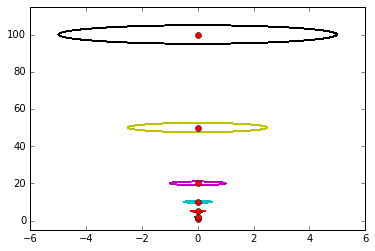

In [22]:
plt.figure()
plt.xlim(-6, 6)
plt.ylim(-5, 115)
for ptcl in range(num_elec):
    plt.plot(ZF0_e[:, Ix, ptcl] / micro,
             ZF0_e[:, Iy, ptcl] / micro)
    plt.plot((ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e)) / micro,
             (- ZI_elec[Ipx, ptcl] / (me * Omega_e)) / micro,
             'or')

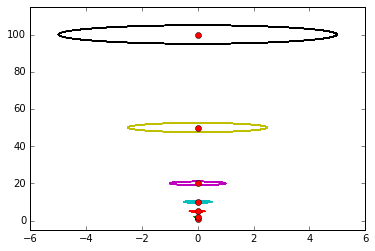

In [23]:
plt.figure()
plt.xlim(-6, 6)
plt.ylim(-5, 115)
for ptcl in range(num_elec):
    plt.plot(ZF_e[:, Ix, ptcl] / micro,
             ZF_e[:, Iy, ptcl] / micro)
    plt.plot((ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e)) / micro,
             (- ZI_elec[Ipx, ptcl] / (me * Omega_e)) / micro,
             'or')

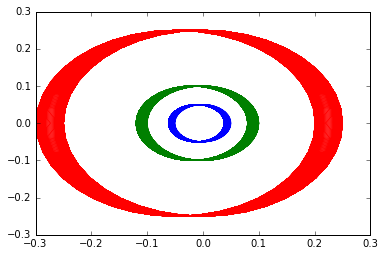

In [24]:
plt.figure()
for ptcl in range(3):
    plt.plot((ZF_e[:, Ix, ptcl]
              - (ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e))) / micro,
             (ZF_e[:, Iy, ptcl]
              - (- ZI_elec[Ipx, ptcl] / (me * Omega_e))) / micro)

In [25]:
4 / 20

0.2

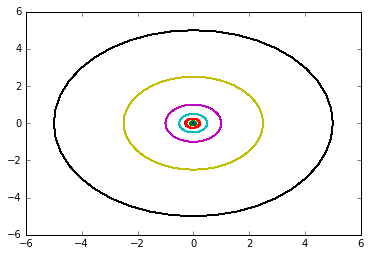

In [26]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot((ZF_e[:, Ix, ptcl]
              - (ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e))) / micro,
             (ZF_e[:, Iy, ptcl]
              - (- ZI_elec[Ipx, ptcl] / (me * Omega_e))) / micro)

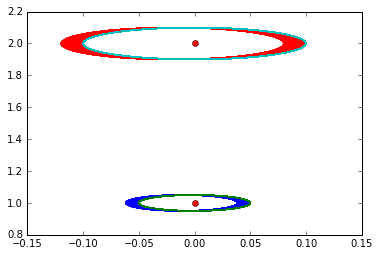

In [27]:
plt.figure()
for ptcl in range(2):
    plt.plot(ZF_e[:, Ix, ptcl] / micro,
             ZF_e[:, Iy, ptcl] / micro)
    plt.plot(ZF0_e[:, Ix, ptcl] / micro,
             ZF0_e[:, Iy, ptcl] / micro)
    plt.plot((ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e)) / micro,
             (- ZI_elec[Ipx, ptcl] / (me * Omega_e)) / micro,
             'ro')
    #plt.plot(0.0, 0.0, 'ro')

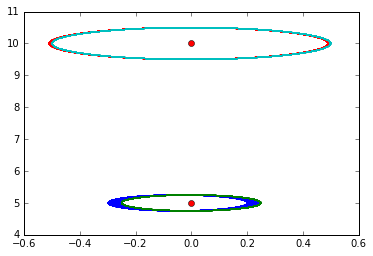

In [28]:
plt.figure()
for ptcl in range(2,4):
    plt.plot(ZF_e[:, Ix, ptcl] / micro,
             ZF_e[:, Iy, ptcl] / micro)
    plt.plot(ZF0_e[:, Ix, ptcl] / micro,
             ZF0_e[:, Iy, ptcl] / micro)
    plt.plot((ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e)) / micro,
             (- ZI_elec[Ipx, ptcl] / (me * Omega_e)) / micro,
             'ro')
    #plt.plot(0.0, 0.0, 'ro')

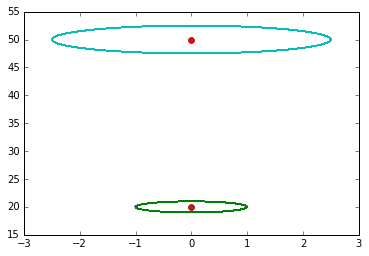

In [29]:
plt.figure()
for ptcl in range(4,6):
    plt.plot(ZF_e[:, Ix, ptcl] / micro,
             ZF_e[:, Iy, ptcl] / micro)
    plt.plot(ZF0_e[:, Ix, ptcl] / micro,
             ZF0_e[:, Iy, ptcl] / micro)
    plt.plot((ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e)) / micro,
             (- ZI_elec[Ipx, ptcl] / (me * Omega_e)) / micro,
             'ro')
    #plt.plot(0.0, 0.0, 'ro')

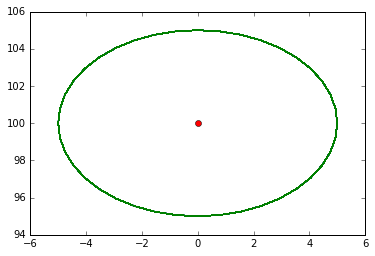

In [30]:
plt.figure()
for ptcl in range(num_elec - 1, num_elec):
    plt.plot(ZF_e[:, Ix, ptcl] / micro,
             ZF_e[:, Iy, ptcl] / micro)
    plt.plot(ZF0_e[:, Ix, ptcl] / micro,
             ZF0_e[:, Iy, ptcl] / micro)
    plt.plot((ZI_elec[Ix, ptcl] + ZI_elec[Ipy, ptcl] / (me * Omega_e)) / micro,
             (- ZI_elec[Ipx, ptcl] / (me * Omega_e)) / micro,
             'ro')
    #plt.plot(0.0, 0.0, 'ro')

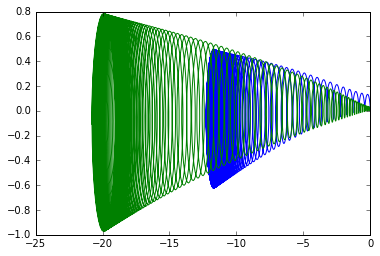

In [31]:
plt.figure()
for ptcl in range(2):
    plt.plot((ZF_e - ZF0_e)[:, Ix, ptcl] / nano,
             (ZF_e - ZF0_e)[:, Iy, ptcl] / nano)

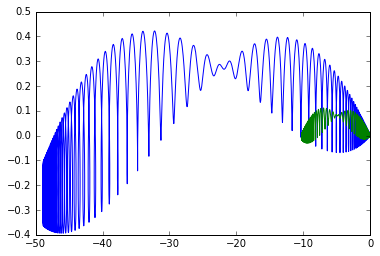

In [32]:
plt.figure()
for ptcl in range(2,4):
    plt.plot((ZF_e - ZF0_e)[:, Ix, ptcl] / nano,
             (ZF_e - ZF0_e)[:, Iy, ptcl] / nano)

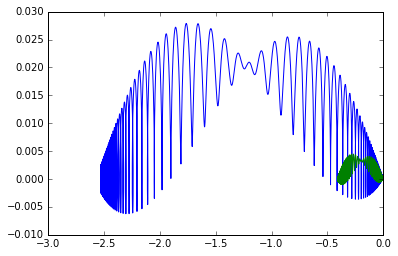

In [33]:
plt.figure()
for ptcl in range(4,6):
    plt.plot((ZF_e - ZF0_e)[:, Ix, ptcl] / nano,
             (ZF_e - ZF0_e)[:, Iy, ptcl] / nano)

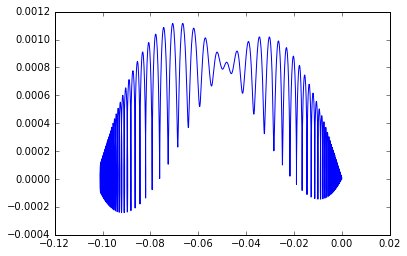

In [34]:
plt.figure()
for ptcl in range(6,7):
    plt.plot((ZF_e - ZF0_e)[:, Ix, ptcl] / nano,
             (ZF_e - ZF0_e)[:, Iy, ptcl] / nano)

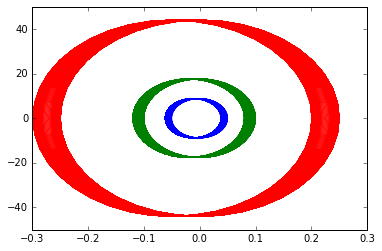

In [35]:
plt.figure()
for ptcl in range(3):
    plt.plot( ZF_e[:, Ix,  ptcl] / micro,
             (ZF_e[:, Ipx, ptcl] - (-qe) * (-B_mag * ZF_e[:, Iy, ptcl])) / me / kilo)

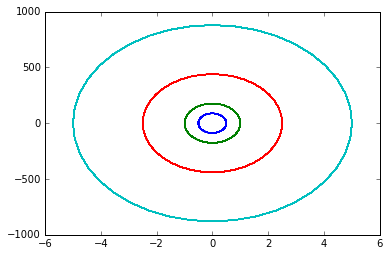

In [36]:
plt.figure()
for ptcl in range(3, num_elec):
    plt.plot( ZF_e[:, Ix,  ptcl] / micro,
             (ZF_e[:, Ipx, ptcl] - (-qe) * (-B_mag * ZF_e[:, Iy, ptcl])) / me / kilo)

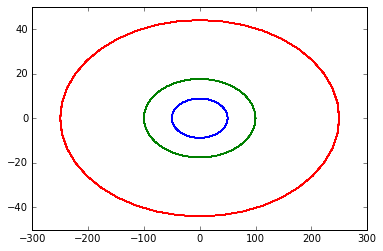

In [37]:
plt.figure()
for ptcl in range(3):
    plt.plot((ZF_e[:, Iy,  ptcl] - (- ZI_elec[Ipx, ptcl] / (me * Omega_e))) / nano,
             ZF_e[:, Ipy, ptcl] / me / kilo)

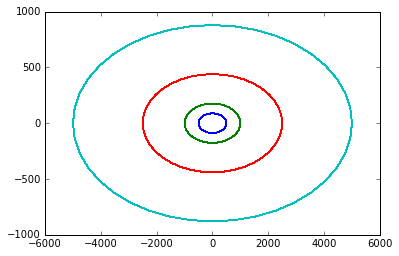

In [38]:
plt.figure()
for ptcl in range(3, num_elec):
    plt.plot((ZF_e[:, Iy,  ptcl] - (- ZI_elec[Ipx, ptcl] / (me * Omega_e))) / nano,
             ZF_e[:, Ipy, ptcl] / me / kilo)

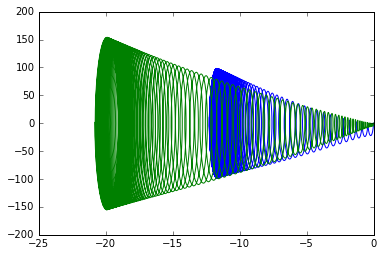

In [39]:
plt.figure()
for ptcl in range(2):
    plt.plot( (ZF_e - ZF0_e)[:, Ix,  ptcl] / nano,
             ((ZF_e - ZF0_e)[:, Ipx, ptcl]
              - (-qe) * (-B_mag * (ZF_e - ZF0_e)[:, Iy, ptcl])) / me / one)

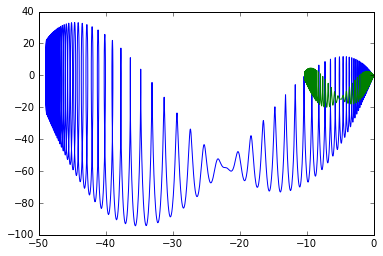

In [40]:
plt.figure()
for ptcl in range(2,4):
    plt.plot( (ZF_e - ZF0_e)[:, Ix,  ptcl] / nano,
             ((ZF_e - ZF0_e)[:, Ipx, ptcl]
              - (-qe) * (-B_mag * (ZF_e - ZF0_e)[:, Iy, ptcl])) / me / one)

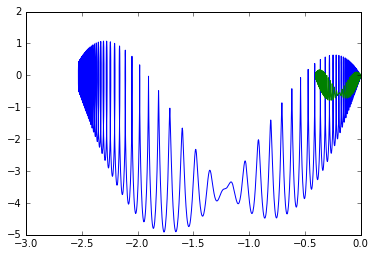

In [41]:
plt.figure()
for ptcl in range(4,6):
    plt.plot( (ZF_e - ZF0_e)[:, Ix,  ptcl] / nano,
             ((ZF_e - ZF0_e)[:, Ipx, ptcl]
              - (-qe) * (-B_mag * (ZF_e - ZF0_e)[:, Iy, ptcl])) / me / one)

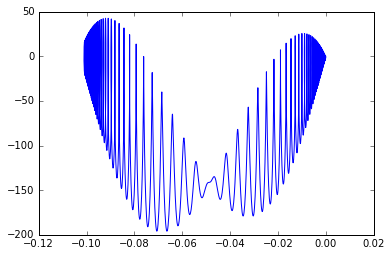

In [42]:
plt.figure()
for ptcl in range(6,7):
    plt.plot( (ZF_e - ZF0_e)[:, Ix,  ptcl] / nano,
             ((ZF_e - ZF0_e)[:, Ipx, ptcl]
              - (-qe) * (-B_mag * (ZF_e - ZF0_e)[:, Iy, ptcl])) / me / milli)

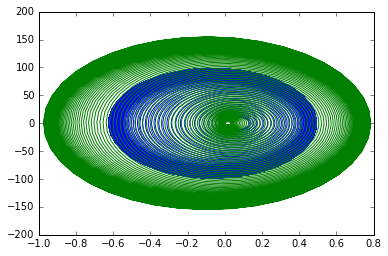

In [43]:
plt.figure()
nst = -1
for ptcl in range(2):
    plt.plot((ZF_e - ZF0_e)[:nst, Iy,  ptcl] / nano,
             (ZF_e - ZF0_e)[:nst, Ipy, ptcl] / me / one)

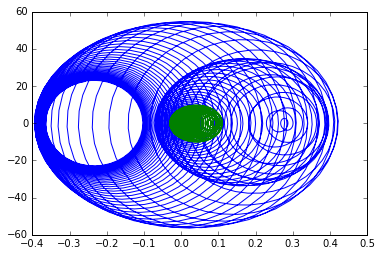

In [44]:
plt.figure()
nst = -1
for ptcl in range(2,4):
    plt.plot((ZF_e - ZF0_e)[:nst, Iy,  ptcl] / nano,
             (ZF_e - ZF0_e)[:nst, Ipy, ptcl] / me / one)

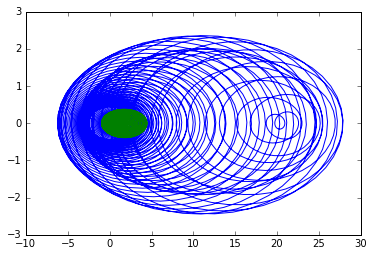

In [45]:
plt.figure()
nst = -1
for ptcl in range(4,6):
    plt.plot((ZF_e - ZF0_e)[:nst, Iy,  ptcl] / pico,
             (ZF_e - ZF0_e)[:nst, Ipy, ptcl] / me / one)

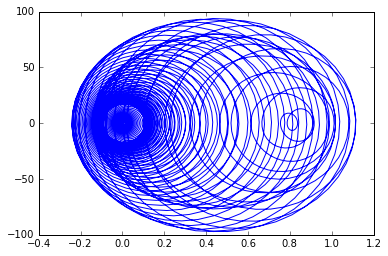

In [46]:
plt.figure()
nst = -1
for ptcl in range(6,7):
    plt.plot((ZF_e - ZF0_e)[:nst, Iy,  ptcl] / pico,
             (ZF_e - ZF0_e)[:nst, Ipy, ptcl] / me / milli)

In [47]:
pRatA = np.asarray(map(lambda zi, ze: pertubationRatioA(zi, toGuidingCenter(ze)), ZF_i, ZF_e))
pRatM = np.asarray(map(lambda zi, ze: pertubationRatioM(zi, toGuidingCenter(ze)), ZF_i, ZF_e))
pRatP = np.asarray(map(lambda zi, ze: pertubationRatioP(zi, toGuidingCenter(ze)), ZF_i, ZF_e))
bDivR = np.asarray(map(lambda zi, ze: impactParamOverRL(zi, toGuidingCenter(ze)), ZF_i, ZF_e))

In [48]:
print pRatA.shape
print pRatM.shape
print pRatP.shape
print bDivR.shape
print nsteps

(4001, 7)
(4001, 7)
(4001, 7)
(4001, 7)
4001


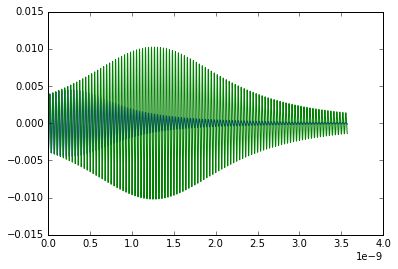

In [49]:
plt.figure()
n0 = 0
n1 = nsteps
times = delta_Te * np.asarray(range(nsteps))
for ptcl in range(2):
    plt.plot(times[n0:n1],
             pRatM[n0:n1, ptcl])

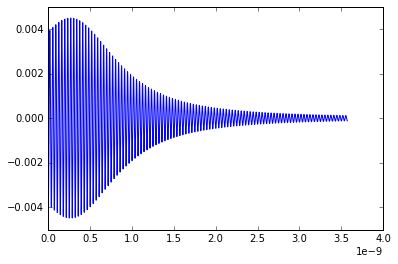

In [50]:
plt.figure()
n0 = 0
n1 = nsteps
times = delta_Te * np.asarray(range(nsteps))
for ptcl in range(1):
    plt.plot(times[n0:n1],
             pRatM[n0:n1, ptcl])

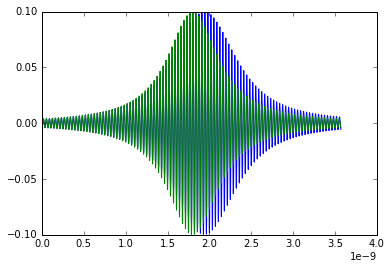

In [51]:
plt.figure()
n0 = 0
n1 = nsteps
times = delta_Te * np.asarray(range(nsteps))
for ptcl in range(2,4):
    plt.plot(times[n0:n1],
             pRatM[n0:n1, ptcl])

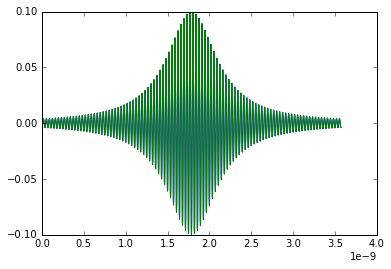

In [52]:
plt.figure()
n0 = 0
n1 = nsteps
times = delta_Te * np.asarray(range(nsteps))
for ptcl in range(4,6):
    plt.plot(times[n0:n1],
             pRatM[n0:n1, ptcl])

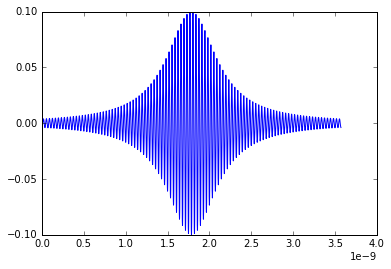

In [53]:
plt.figure()
n0 = 0
n1 = nsteps
times = delta_Te * np.asarray(range(nsteps))
for ptcl in range(6,7):
    plt.plot(times[n0:n1],
             pRatM[n0:n1, ptcl])

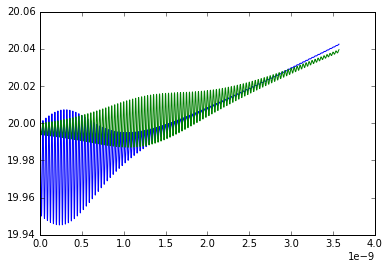

In [54]:
plt.figure()
for ptcl in range(2):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             -bDivR[:, ptcl])

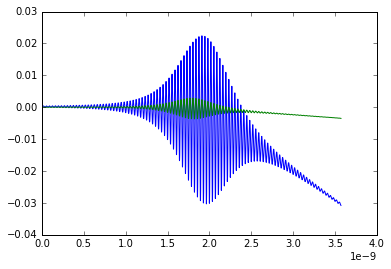

In [55]:
plt.figure()
for ptcl in range(2,4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             20 - np.abs(bDivR[:, ptcl]))

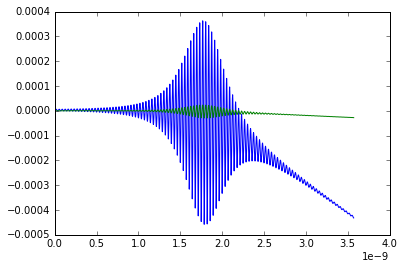

In [56]:
plt.figure()
for ptcl in range(4,6):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             20 - np.abs(bDivR[:, ptcl]))

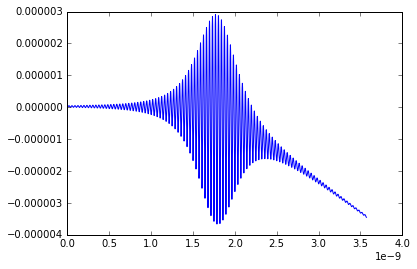

In [57]:
plt.figure()
for ptcl in range(6,7):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             20 - np.abs(bDivR[:, ptcl]))

In [58]:
# Delta-P_ion, calculated from the explicit map
(ZF_i[-1, [Ipx, Ipy, Ipz], :] - ZF_i[0, [Ipx, Ipy, Ipz], :]).T

array([[  1.04731000e-29,  -1.87486233e-27,   1.11776417e-26],
       [  1.57964617e-29,  -3.19210504e-27,   1.16128060e-26],
       [  3.82365713e-29,  -7.82630958e-27,   1.30850925e-28],
       [  8.48136431e-31,  -1.64831816e-27,   2.81822559e-30],
       [  2.56090569e-32,  -4.05057800e-28,   8.49342631e-32],
       [  2.61062056e-34,  -6.46638699e-29,   8.65627746e-34],
       [  8.15600456e-36,  -1.61638017e-29,   2.70432463e-35]])

In [59]:
ZI_elec_gc = toGuidingCenter(ZI_elec)
ZFgc_i, ZFgc_e = apply_MapZgc(delta_Te, num_steps, ZI_ion, ZI_elec_gc)

In [105]:
4000 / 400

10.0

In [95]:
ZFgc_x_i, ZFgc_x_e = apply_MapZgc(40 * delta_Te, num_steps // 40, ZI_ion, ZI_elec_gc)
print (ZFgc_x_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_x_i[0, [Ipx, Ipy, Ipz], :]).T

[[  1.05836708e-26   5.67504416e-26   8.51768805e-28]
 [  4.92999849e-28   1.77610316e-26   1.73512631e-27]
 [  1.99946520e-29   5.65951484e-27   6.59695843e-29]
 [  7.81439841e-31   1.58238970e-27   2.59745819e-30]
 [  2.52290585e-32   4.02100988e-28   8.39947806e-32]
 [  2.59499163e-34   6.44797194e-29   8.64146934e-34]
 [  8.11151685e-36   1.61220857e-29   2.70121883e-35]]


In [99]:
ZFgc_x_i, ZFgc_x_e = apply_MapZgc(80 * delta_Te, num_steps // 80, ZI_ion, ZI_elec_gc)
print (ZFgc_x_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_x_i[0, [Ipx, Ipy, Ipz], :]).T

[[  2.14817657e-27   2.61350551e-26  -2.18295742e-27]
 [  4.90448210e-28   1.77150755e-26   1.74567430e-27]
 [  1.99870730e-29   5.65844276e-27   6.59521178e-29]
 [  7.81409557e-31   1.58235906e-27   2.59685491e-30]
 [  2.52291810e-32   4.02101964e-28   8.39756844e-32]
 [  2.59501942e-34   6.44800646e-29   8.63951055e-34]
 [  8.11160656e-36   1.61221749e-29   2.70060664e-35]]


In [106]:
ZFgc_x_i, ZFgc_x_e = apply_MapZgc(160 * delta_Te, num_steps // 160, ZI_ion, ZI_elec_gc)
print (ZFgc_x_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_x_i[0, [Ipx, Ipy, Ipz], :]).T

[[  5.20096310e-26   1.16988782e-25   1.29139359e-26]
 [  4.73388458e-28   1.74041833e-26   2.62007515e-27]
 [  1.99553678e-29   5.65395568e-27   6.56948668e-29]
 [  7.81288077e-31   1.58223614e-27   2.59691645e-30]
 [  2.52297364e-32   4.02106393e-28   8.39534757e-32]
 [  2.59513811e-34   6.44815393e-29   8.63690068e-34]
 [  8.11198910e-36   1.61225550e-29   2.69978481e-35]]


In [107]:
ZFgc_x_i, ZFgc_x_e = apply_MapZgc(400 * delta_Te, num_steps // 400, ZI_ion, ZI_elec_gc)
print (ZFgc_x_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_x_i[0, [Ipx, Ipy, Ipz], :]).T

[[  2.23422346e-28   8.45718951e-27  -1.53901390e-26]
 [  1.00821652e-26   7.93120021e-26   1.42130883e-26]
 [  1.98058416e-29   5.63275859e-27  -1.41768453e-28]
 [  7.57240857e-31   1.55769655e-27  -3.26299395e-30]
 [  2.45879477e-32   3.96959114e-28  -7.87120484e-32]
 [  2.53116752e-34   6.36818402e-29  -7.71914090e-34]
 [  7.91241310e-36   1.59229916e-29  -2.40580996e-35]]


In [60]:
(ZFgc_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_i[0, [Ipx, Ipy, Ipz], :]).T

array([[  1.06736119e-26,   5.69619435e-26,   1.21445745e-27],
       [  4.93897920e-28,   1.77771766e-26,   1.73546012e-27],
       [  1.99971566e-29,   5.65986907e-27,   6.59754096e-29],
       [  7.81449851e-31,   1.58239983e-27,   2.59765932e-30],
       [  2.52290174e-32,   4.02100659e-28,   8.40011469e-32],
       [  2.59498236e-34,   6.44796043e-29,   8.64212236e-34],
       [  8.11148695e-36,   1.61220560e-29,   2.70142291e-35]])

In [61]:
magnus_deltaPIon(T_intxn, ZI_ion, ZI_elec_gc)

array([[  0.00000000e+00,  -1.61222627e-25,   1.01894869e-40],
       [  0.00000000e+00,  -4.03058781e-26,   0.00000000e+00],
       [  0.00000000e+00,  -6.44894524e-27,   0.00000000e+00],
       [  0.00000000e+00,  -1.61223638e-27,   0.00000000e+00],
       [  0.00000000e+00,  -4.03059097e-28,   3.26065589e-43],
       [  0.00000000e+00,  -6.44894556e-29,  -6.67782327e-44],
       [  0.00000000e+00,  -1.61223639e-29,   0.00000000e+00]])

In [65]:
# will have to fix sign issues
deltaP_exp = np.abs(ZF_i[-1, [Ipx, Ipy, Ipz], :] - ZF_i[0, [Ipx, Ipy, Ipz], :]).T
deltaP_avg = (ZFgc_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_i[0, [Ipx, Ipy, Ipz], :]).T
deltaP_mgn = np.abs(magnus_deltaPIon(T_intxn, ZI_ion, ZI_elec_gc))

dDeltaP_ax = deltaP_avg - deltaP_exp
dDeltaP_mx = deltaP_mgn - deltaP_exp

relErr_avg = (np.linalg.norm(dDeltaP_ax, axis = 1)
             / np.linalg.norm(deltaP_exp, axis = 1))
relErr_mgn = (np.linalg.norm(dDeltaP_mx, axis = 1)
             / np.linalg.norm(deltaP_exp, axis = 1))

print "|ΔP_avg - ΔP_exp| =\n", np.linalg.norm(dDeltaP_ax, axis = 1)
print "|ΔP_mgn - ΔP_exp| =\n", np.linalg.norm(dDeltaP_mx, axis = 1)
print 
print "|ΔP_exp| =\n", np.linalg.norm(deltaP_avg, axis = 1)
print 
print "relErr_avg / % =\n", 100 * relErr_avg
print "relErr_mgn / % =\n", 100 * relErr_mgnLogLogP
print 
print "log_10(relErr_avg) =\n", np.log10(relErr_avg)
print "log_10(relErr_mgn) =\n", np.log10(relErr_mgn)
print 

print "b / μm =\n", impactParameterB / micro

|ΔP_avg - ΔP_exp| =
[  5.69873151e-26   1.76214317e-26   2.16748840e-27   6.59187337e-29   2.95714103e-30
   1.84265614e-31   4.17457403e-32]
|ΔP_mgn - ΔP_exp| =
[  1.59739318e-25   3.88881687e-26   1.38409412e-27   3.62016096e-29   2.00067077e-30
   1.74416637e-31   4.14378430e-32]

|ΔP_exp| =
[  5.79660582e-26   1.78685132e-26   5.66028891e-27   1.58240215e-27   4.02100669e-28
   6.44796043e-29   1.61220560e-29]

relErr_avg / % =
[  5.02808802e+02   1.46314290e+02   2.76906969e+01   3.99914472e+00   7.30054070e-01
   2.84959150e-01   2.58266842e-01]
relErr_mgn / % =
[  1.40940725e+03   3.22896282e+02   1.76824617e+01   2.19627210e+00   4.93922281e-01
   2.69728114e-01   2.56361985e-01]

log_10(relErr_avg) =
[ 0.70140287  0.16528674 -0.55766611 -1.39803288 -2.13664497 -2.54521739 -2.58793135]
log_10(relErr_mgn) =
[ 1.1490365   0.50906304 -0.75245727 -1.65831386 -2.30634138 -2.56907378 -2.59114637]

b / μm =
[   1.    2.    5.   10.   20.   50.  100.]


In [66]:
eV_closest_approach = (invFourPiEps0 * Z_ion * qe ** 2 / impactParameterB)
E_kinetic_e = (me / 2) * (V_perp ** 2 + V_z ** 2)
print "E_pot_ca =\n", eV_closest_approach
print "E_kin =\n", E_kinetic_e
print 
print "E_pot_ca / E_kin =\n", (eV_closest_approach / E_kinetic_e)
print 
print "log_10(E_pot_ca / E_kin) =\n", np.log10(eV_closest_approach / E_kinetic_e)

E_pot_ca =
[  2.30707751e-22   1.15353876e-22   4.61415503e-23   2.30707751e-23   1.15353876e-23
   4.61415503e-24   2.30707751e-24]
E_kin =
[  3.87932171e-23   1.55172869e-22   9.69830428e-22   3.87932171e-21   1.55172869e-20
   9.69830428e-20   3.87932171e-19]

E_pot_ca / E_kin =
[  5.94711572e+00   7.43389465e-01   4.75769257e-02   5.94711572e-03   7.43389465e-04
   4.75769257e-05   5.94711572e-06]

log_10(E_pot_ca / E_kin) =
[ 0.77430639 -0.1287836  -1.32260362 -2.22569361 -3.1287836  -4.32260362 -5.22569361]


In [78]:
mae_compare = plt.figure()

my_font_12 = {'fontname' : 'Arial', 'size' : '12'}
my_font_14 = {'fontname' : 'Arial', 'size' : '14'}
plt.rc('font', **my_font_12)
plt.loglog(eV_closest_approach / E_kinetic_e, relErr_avg, 'bo')
plt.loglog(eV_closest_approach / E_kinetic_e, relErr_mgn, 'rs')
plt.xlabel("$eV_{\mathrm{ca}} / E_{\mathrm{kin}}$")
plt.ylabel("relative error in $\Delta{P}_{\mathrm{ion}}$")
plt.annotate(s="bar",xy=(0.001,1))

plt.text(0.1,0.01, "foo", rotation = 45)

plt.show()

KeyError: u'Unrecognized key "font.fontname" for group "font" and name "fontname"'

In [ ]:
mae_compare.savefig("/Users/dabell/RadiaSoft/MCool/MgnAvgExpCompare.pdf")

In [62]:
# will have to fix sign issues
deltaP_avg = np.abs(ZF_i[-1, [Ipx, Ipy, Ipz], :] - ZF_i[0, [Ipx, Ipy, Ipz], :]).T
deltaP_exp = (ZFgc_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_i[0, [Ipx, Ipy, Ipz], :]).T
deltaP_mgn = np.abs(magnus_deltaPIon(T_intxn, ZI_ion, ZI_elec_gc))

dDeltaP_ax = deltaP_avg - deltaP_exp
dDeltaP_mx = deltaP_mgn - deltaP_exp

relErr_avg = (np.linalg.norm(dDeltaP_ax, axis = 1)
             / np.linalg.norm(deltaP_exp, axis = 1))
relErr_mgn = (np.linalg.norm(dDeltaP_mx, axis = 1)
             / np.linalg.norm(deltaP_exp, axis = 1))

print "|ΔP_avg - ΔP_exp| =\n", np.linalg.norm(dDeltaP_ax, axis = 1)
print "|ΔP_mgn - ΔP_exp| =\n", np.linalg.norm(dDeltaP_mx, axis = 1)
print 
print "|ΔP_exp| =\n", np.linalg.norm(deltaP_avg, axis = 1)
print 
print "relErr_avg / % =\n", 100 * relErr_avg
print "relErr_mgn / % =\n", 100 * relErr_mgn
print 
print "log_10(relErr_avg) =\n", np.log10(relErr_avg)
print "log_10(relErr_mgn) =\n", np.log10(relErr_mgn)
print 

print "b / μm =\n", impactParameterB / micro

|ΔP_avg - ΔP_exp| =
[  5.69873151e-26   1.76214317e-26   2.16748840e-27   6.59187337e-29   2.95714103e-30
   1.84265614e-31   4.17457403e-32]
|ΔP_mgn - ΔP_exp| =
[  1.04812647e-25   2.26008440e-26   7.92081958e-28   2.99596113e-29   9.62442580e-31
   9.89255845e-33   3.09196085e-34]

|ΔP_exp| =
[  1.13337943e-26   1.20435480e-26   7.82749677e-27   1.64832079e-27   4.05057810e-28
   6.46638699e-29   1.61638017e-29]

relErr_avg / % =
[ 98.31152375  98.61722408  38.29289343   4.16573837   0.73542306   0.28577349   0.25893559]
relErr_mgn / % =
[  1.80817275e+02   1.26484189e+02   1.39936666e+01   1.89329945e+00   2.39353638e-01
   1.53421513e-02   1.91784525e-03]

log_10(relErr_avg) =
[-0.00739557 -0.00604723 -0.41688182 -1.38030801 -2.13346276 -2.54397807 -2.58680826]
log_10(relErr_mgn) =
[ 0.25723992  0.10203624 -0.85406848 -1.72278069 -2.62095997 -3.81411374 -4.71718644]

b / μm =
[   1.    2.    5.   10.   20.   50.  100.]


In [63]:
eV_closest_approach = (invFourPiEps0 * Z_ion * qe ** 2 / impactParameterB)
E_kinetic_e = (me / 2) * (V_perp ** 2 + V_z ** 2)
print "E_pot_ca =\n", eV_closest_approach
print "E_kin =\n", E_kinetic_e
print 
print "E_pot_ca / E_kin =\n", (eV_closest_approach / E_kinetic_e)
print 
print "log_10(E_pot_ca / E_kin) =\n", np.log10(eV_closest_approach / E_kinetic_e)

E_pot_ca =
[  2.30707751e-22   1.15353876e-22   4.61415503e-23   2.30707751e-23   1.15353876e-23
   4.61415503e-24   2.30707751e-24]
E_kin =
[  3.87932171e-23   1.55172869e-22   9.69830428e-22   3.87932171e-21   1.55172869e-20
   9.69830428e-20   3.87932171e-19]

E_pot_ca / E_kin =
[  5.94711572e+00   7.43389465e-01   4.75769257e-02   5.94711572e-03   7.43389465e-04
   4.75769257e-05   5.94711572e-06]

log_10(E_pot_ca / E_kin) =
[ 0.77430639 -0.1287836  -1.32260362 -2.22569361 -3.1287836  -4.32260362 -5.22569361]


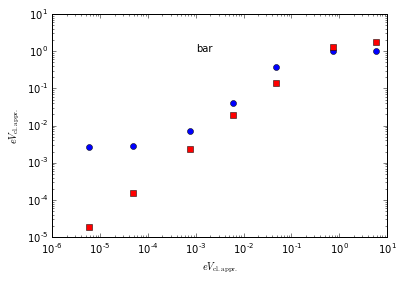

In [64]:
llres = plt.figure()
plt.loglog(eV_closest_approach / E_kinetic_e, relErr_avg, 'bo')
plt.loglog(eV_closest_approach / E_kinetic_e, relErr_mgn, 'rs')
plt.xlabel("$eV_{\mathrm{cl.appr.}}$")
plt.ylabel("$eV_{\mathrm{cl.appr.}}$")
plt.annotate(s="bar",xy=(0.001,1))
plt.show()

llres.savefig("/Users/dabell/Desktop/foo.pdf")

In [ ]:
num_steps_per_gyro = 80
delta_Te = T_e / num_steps_per_gyro
num_steps = int(np.floor(T_intxn / delta_Te))
print "num_steps =", num_steps

In [ ]:
ZF0_i, ZF0_e = apply_MapZ_0(delta_Te, num_steps, ZI_ion, ZI_elec)

In [ ]:
ZF_i, ZF_e = apply_MapZ(delta_Te, num_steps, ZI_ion, ZI_elec)

In [ ]:
ZF0gc_e = np.asarray(map(toGuidingCenter, ZF0_e))
ZFgc_e = np.asarray(map(toGuidingCenter, ZF_e))

In [ ]:
nsteps = ZF0_e.shape[0]

In [ ]:
H2b_0 = np.asarray(map(lambda zi, ze: H_twobody_0(zi, ze), ZF0_i, ZF0_e))
H2b   = np.asarray(map(lambda zi, ze: H_twobody(zi, ze), ZF_i, ZF_e))

m2r2_0 = np.asarray(map(lambda zi, ze: minus2RLsq(zi, ze), ZF0_i, ZF0gc_e))
p2r2_0 = np.asarray(map(lambda zi, ze: plus2RLsq(zi, ze), ZF0_i, ZF0gc_e))

m2r2 = np.asarray(map(lambda zi, ze: minus2RLsq(zi, ze), ZF_i, ZFgc_e))
p2r2 = np.asarray(map(lambda zi, ze: plus2RLsq(zi, ze), ZF_i, ZFgc_e))

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b_0[:, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b_0[:, ptcl] - H2b_0[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(0, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b_0[:, ptcl] - H2b_0[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(1, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b_0[:, ptcl] - H2b_0[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(2, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b_0[:, ptcl] - H2b_0[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(3, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b_0[:, ptcl] - H2b_0[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(0, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(1, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(2, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(3, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             H2b[:, ptcl] - H2b[0, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             ZF0gc_e[:, Ipx, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             ZF0gc_e[:, Ipx, ptcl] - ZF0gc_e[0, Ipx, ptcl])

In [ ]:
plt.figure()
for ptcl in range(0, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             ZF0gc_e[:, Ipx, ptcl] - ZF0gc_e[0, Ipx, ptcl])

In [ ]:
plt.figure()
for ptcl in range(1, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             ZF0gc_e[:, Ipx, ptcl] - ZF0gc_e[0, Ipx, ptcl])

In [ ]:
plt.figure()
for ptcl in range(2, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             ZF0gc_e[:, Ipx, ptcl] - ZF0gc_e[0, Ipx, ptcl])

In [ ]:
plt.figure()
for ptcl in range(3, 16, 4):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             ZF0gc_e[:, Ipx, ptcl] - ZF0gc_e[0, Ipx, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             p2r2_0[:, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             p2r2[:, ptcl] - p2r2_0[:, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             m2r2[:, ptcl] - m2r2_0[:, ptcl])

In [ ]:



plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             m2r2_0[:, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             m2r2[:, ptcl])

In [ ]:
plt.figure()
ptcl = 0
plt.plot(delta_Te * np.asarray(range(nsteps)),
         m2r2[:, ptcl])
plt.plot(delta_Te * np.asarray(range(nsteps)),
         p2r2[:, ptcl])

In [ ]:
plt.figure()
ptcl = 4
plt.plot(delta_Te * np.asarray(range(nsteps)),
         m2r2[:, ptcl])
plt.plot(delta_Te * np.asarray(range(nsteps)),
         p2r2[:, ptcl])

In [ ]:
plt.figure()
ptcl = 7
plt.plot(delta_Te * np.asarray(range(nsteps)),
         m2r2[:, ptcl])
plt.plot(delta_Te * np.asarray(range(nsteps)),
         p2r2[:, ptcl])

In [ ]:
ZI_elec_gc = toGuidingCenter(ZI_elec)
ZFgc_i, ZFgc_e = apply_MapZgc(delta_Te, num_steps, ZI_ion, ZI_elec_gc)

In [ ]:
(ZFgc_i[-1, [Ipx, Ipy], :] - ZFgc_i[0, [Ipx, Ipy], :]).T

In [ ]:
(ZFgc_i[-1, [Ipx, Ipy], :] - ZFgc_i[0, [Ipx, Ipy], :]).T

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(ZFgc_e[:, Iy,  ptcl] / micro,
             ZFgc_e[:, Ipy, ptcl] / me / mega)

In [ ]:
nsteps = ZFgc_i.shape[0]
nsteps

In [ ]:
hgc = []
for i in range(nsteps):
    hgc.append(H_gc(ZFgc_i[i], ZFgc_e[i]))
hgc = np.asarray(hgc)

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             hgc[:, ptcl])

In [ ]:
plt.figure()
ptcl = 6
plt.plot(delta_Te * np.asarray(range(nsteps)),
         hgc[:, ptcl])

In [ ]:
plt.figure()
ptcl = 6
plt.plot(delta_Te * np.asarray(range(nsteps)),
         hgc[:, ptcl])

In [ ]:
plt.figure()
for ptcl in range(num_elec):
    plt.plot(delta_Te * np.asarray(range(nsteps)),
             hgc[:, ptcl])